# Data preparation

## Library import

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Flatten
from tensorflow.keras.optimizers import legacy

from sklearn.preprocessing import MinMaxScaler

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.font_manager as font_manager

import time

## Use Colissimo font for Matplotlib

In [2]:
font_path = 'Font/Monserrat/Montserrat-Regular.otf'

font_manager.fontManager.addfont(font_path)

plt.rcParams['font.family'] = 'Montserrat'

## Read dataset

In [3]:
# Read main data
data = pd.read_excel('data/traffic_tg1.xlsx', index_col='date')
data.index = pd.to_datetime(data.index)

# Read holiday day data
holidays_data = pd.read_excel('data/public_holiday.xlsx')
holidays_data['date'] = pd.to_datetime(holidays_data['date'])

## Create dummies

In [4]:
#Create dummies

# Create a dummy for holiday
data['is_holiday'] = data.index.isin(holidays_data['date']).astype(int)

# Function creation

## Custom MAPE/MAE function loss

In [5]:
def custom_mape(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs((y_true_masked - y_pred_masked) / y_true_masked)
    return 100. * tf.reduce_mean(diff)

def custom_mae(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    mask = tf.math.greater(y_true, 0)
    y_true_masked = tf.boolean_mask(y_true, mask)
    y_pred_masked = tf.boolean_mask(y_pred, mask)

    diff = tf.abs(y_true_masked - y_pred_masked)
    return 100. * tf.reduce_mean(diff)

## CNN model

In [6]:
# Define a function to create a sequential CNN model
def create_cnn_model(filters, kernel_size, activation, n_steps_in, n_features, optimizer, loss):
    model = Sequential()
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation=activation, 
                     input_shape=(n_steps_in, n_features)))
    model.add(Conv1D(filters=filters, 
                     kernel_size=7, 
                     activation=activation))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=[custom_mape, custom_mae])
    return model

def create_cnn_model(filters, kernel_size, activation, n_steps_in, n_features, optimizer, loss, 
                     reg_type=None, l1_value=0.0, l2_value=0.0):
    if reg_type == 'l1':
        kernel_regularizer = l1(l1_value)
    elif reg_type == 'l2':
        kernel_regularizer = l2(l2_value)
    elif reg_type == 'l1_l2':
        kernel_regularizer = l1_l2(l1=l1_value, l2=l2_value)
    else:
        kernel_regularizer = None
    
    model = Sequential()
    model.add(Conv1D(filters=filters, 
                     kernel_size=kernel_size, 
                     activation=activation, 
                     kernel_regularizer=kernel_regularizer, 
                     input_shape=(n_steps_in, n_features)))
    model.add(Conv1D(filters=filters, 
                     kernel_size=5, 
                     activation=activation, 
                     kernel_regularizer=kernel_regularizer))
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss, metrics=[custom_mape, custom_mae])
    return model

## Scale data

In [7]:
# Scale data between 0 and 1
def scale_data(data):
    scalers = {}
    data_normalized = data.copy()
    for column in data.columns:
        scaler = MinMaxScaler()
        data_normalized[column] = scaler.fit_transform(data[[column]])
        scalers[column] = scaler
    return data_normalized, scalers

## Data transformation

In [8]:
# Define a function to transfrom data for CNN model
def transform_data_cnn(data_normalized, n_steps_in, start_date, end_date):    
    X, y, dates = [], [], []
    # Filter data based on the start and end dates
    data_filtered = data_normalized[start_date:end_date]
    # Create sequence data of n_steps_in days and n_steps_out days
    for i in range(n_steps_in, len(data_filtered)):
        X.append(data_filtered.iloc[i-n_steps_in:i])
        y.append(data_filtered.iloc[i]['tg1_traffic']) #0 because we just want to predict traffic
        dates.append(data_filtered.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)
    return X, y, dates




## Transfer learning

In [9]:
def transfer_learning(X_train, y_train, n_steps_in, model_params, test_dates, y_test, cnn_model):
    # Initialize empty list to save forecast
    daily_predictions = []
    eight_day_predictions = [0] * len(test_dates)
    
    for i, date in enumerate(test_dates):
        
        # Get traffic of last day to update X_train
        if i == 0:
            new_traffic_point = y_train[-1] # for first forecast, need to take last traffic in train data
        else:
            new_traffic_point = y_test[i-1]
            
        # Create dummies for new datapoint
        current_date = test_dates[i] # forecast's day
        is_holiday = 1 if current_date in holidays_data['date'].values else 0

        # Create new data point with traffic and dummies
        new_data_point = [new_traffic_point, is_holiday]
        new_data_point_array=np.array([new_data_point])

        # Update X_train and y_train
        new_X = np.append(X_train[-1][1:], new_data_point_array, axis=0)
        X_train = np.append(X_train, [new_X], axis=0)
        y_train = np.append(y_train, [y_test[i]])
    
        # Quick update of model for learning transfer
        print('Training for ',current_date)
        cnn_model.fit(X_train, y_train, epochs=1, verbose=0)

        # Make 1-day forecast
        
        prediction = cnn_model.predict(X_train[-1].reshape(1, n_steps_in, 2)) 
        daily_predictions.append(prediction[0])
        
        # if current date is a Thursday, need to make a 8-day forecast
        if date.weekday() == 3:
            eight_days_data = X_train[-1]
            local_predictions = []
            for k in range(6):
                if i + k < len(test_dates):  # Check that the index does not go beyond the length of test_dates
                    current_date = test_dates[i+k]
                    print(current_date)
                    is_holiday = 1 if current_date in holidays_data['date'].values else 0

                    # Créez un nouveau point de données avec le trafic et les dummies
                    new_prediction_point = [prediction[0][0], is_holiday]
                    new_prediction_point_array = np.array([new_prediction_point])
                    eight_days_data = np.append(eight_days_data[1:], new_prediction_point_array, axis=0)
                    prediction = cnn_model.predict(eight_days_data.reshape(1, n_steps_in, 2))
                    local_predictions.append(prediction[0])
            for j in range(min(5, len(local_predictions)-1)):
                index_to_assign = i+2+j
                print(index_to_assign)
                if index_to_assign < len(eight_day_predictions):
                    eight_day_predictions[index_to_assign] = local_predictions[1+j][0]




    return daily_predictions, eight_day_predictions



## Rescale data

In [10]:
def rescale_predictions(predictions, scaler):
    predictions_array = np.array(predictions)
    return scaler.inverse_transform(predictions_array.reshape(-1, 1))

## Plot test results

In [11]:
def plot_test_results_from_df(df, title):
    plt.figure(figsize=(15, 7))
    plt.title(title)
    
    # Extraire les données du DataFrame
    test_dates = df.index
    y_test = df['Trafic TG1'].values
    y_test_forecast = df['Prévision globale'].values
    daily_forecast = df['Prévision journalière'].values
    weekly_forecast = df['Prévision hebdomadaire'].values

    # Remplir la zone d'erreur acceptable (+-5%)
    upper_bound = [val * 1.05 for val in y_test]
    lower_bound = [val * 0.95 for val in y_test]
    plt.fill_between(test_dates, upper_bound, lower_bound, color='blue', alpha=0.2)
    
    # Affichage de la prévision lancée d'un coup
    plt.plot(test_dates, y_test_forecast, label='Prévision globale', color='green', marker='o')
    
    # Affichage des prévisions quotidiennes
    plt.plot(test_dates, daily_forecast, label='Prévision journalière', color='red', marker='x')
    
    # Affichage des prévisions hebdomadaires
    plt.plot(test_dates, weekly_forecast, label='Prévision hebdomadaire', color='purple', marker='s')
    
    # Affichage du trafic réel    
    plt.plot(test_dates, y_test, label='Trafic réel', color='blue', linewidth=2)
    

    plt.xlabel('Date')
    plt.ylabel('Trafic')
    plt.legend()
    plt.grid(False)
    plt.show()

## Plot train results

In [12]:
def plot_train_results_from_df(df, title):
    plt.figure(figsize=(15, 7))
    plt.title(title)
    
    # Extraire les données du DataFrame
    train_dates = df.index
    y_train = df['Trafic TG1'].values
    y_train_forecast = df['Prévision globale'].values

    # Remplir la zone d'erreur acceptable (+-5%)
    upper_bound = [val * 1.05 for val in y_train]
    lower_bound = [val * 0.95 for val in y_train]
    plt.fill_between(train_dates, upper_bound, lower_bound, color='blue', alpha=0.2)
    

    
    
    # Affichage du trafic réel    
    plt.plot(train_dates, y_train, label='Trafic réel', color='blue')
    # Affichage de la prévision lancée d'un coup
    plt.plot(train_dates, y_train_forecast, label='Prévision globale', color='green', linewidth = 2)
    

    plt.xlabel('Date')
    plt.ylabel('Trafic')
    plt.legend()
    plt.grid(False)
    plt.show()

## Calculate MAPE

In [13]:
def calculate_mape(actual, forecast):
    # Éviter la division par zéro et les erreurs NaN
    mask = actual != 0
    return np.mean(np.abs((actual[mask] - forecast[mask]) / actual[mask])) * 100

def compute_mape_for_columns(df, actual_col, forecast_cols):
    mape_values = {}
    for col in forecast_cols:
        valid_forecast_mask = ~df[col].isna()
        mape = calculate_mape(df[actual_col][valid_forecast_mask], df[col][valid_forecast_mask])
        mape_values[col] = mape
    return mape_values

# Data preparation

Take out saturday and sunday of data, normalized the data before creating training and test dataset.
<br>
n_steps_in is the number of week $\times$ number of day in a week (here 5)

In [58]:
data = data[(data.index.dayofweek != 5) & (data.index.dayofweek != 6)]

data_normalized, scaler = scale_data(data)

n_steps_in =260

X_train, y_train, train_dates = transform_data_cnn(data_normalized, 
                                                   n_steps_in,  
                                                   '2017-01-01', 
                                                   '2022-12-31')

X_test, y_test, test_dates = transform_data_cnn(data_normalized, 
                                                n_steps_in, 
                                                '2022-01-01', 
                                                '2023-01-15')

# Model creation

## Model parameters

In [95]:
# Paramètres du modèle
model_params = {
    "filters": 128,
    "kernel_size": 20,
    "activation": "relu",
    "n_steps_in": n_steps_in,
    "n_features": 2,
    "optimizer": 'adam',
    "loss": custom_mape
}

## Model creation

In [133]:
cnn_model = create_cnn_model(**model_params)
cnn_model.fit(X_train, y_train, epochs=80)

Epoch 1/80
 1/41 [..............................] - ETA: 15s - loss: 96.9217 - custom_mape: 96.9217 - custom_mae: 37.8147

2023-08-30 09:59:37.530791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


41/41 [==============================] - 1s 17ms/step - loss: 45.7221 - custom_mape: 45.6615 - custom_mae: 15.0664
Epoch 2/80
41/41 [==============================] - 0s 12ms/step - loss: 29.8813 - custom_mape: 29.9065 - custom_mae: 9.6029
Epoch 3/80
41/41 [==============================] - 1s 13ms/step - loss: 24.5323 - custom_mape: 24.6134 - custom_mae: 8.7788
Epoch 4/80
41/41 [==============================] - 1s 12ms/step - loss: 32.6208 - custom_mape: 32.5812 - custom_mae: 10.5803
Epoch 5/80
41/41 [==============================] - 1s 13ms/step - loss: 25.2344 - custom_mape: 26.0446 - custom_mae: 7.8141
Epoch 6/80
41/41 [==============================] - 0s 11ms/step - loss: 30.0207 - custom_mape: 30.0151 - custom_mae: 10.9758
Epoch 7/80
41/41 [==============================] - 1s 12ms/step - loss: 20.4460 - custom_mape: 20.6402 - custom_mae: 7.0601
Epoch 8/80
41/41 [==============================] - 0s 12ms/step - loss: 21.7779 - custom_mape: 21.8054 - custom_mae: 7.1407
Epoch 9/

## Global forecast

In [110]:
y_train_forecast = cnn_model.predict(X_train)
y_test_forecast = cnn_model.predict(X_test)

41/41 [==============================] - 0s 4ms/step


2023-08-30 09:58:30.904093: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 19ms/step


## Daily and Weekly Forecast

In [111]:
start_time = time.time()
daily_forecast, weekly_forecast = transfer_learning(X_train,y_train,n_steps_in,model_params,test_dates,y_test,cnn_model)
print("--- Transfert d'apprentissage: %s seconds ---" % (time.time() - start_time))

Training for  2023-01-02 00:00:00
1/1 [==============================] - 0s 19ms/step
Training for  2023-01-03 00:00:00
1/1 [==============================] - 0s 9ms/step
Training for  2023-01-04 00:00:00
1/1 [==============================] - 0s 10ms/step
Training for  2023-01-05 00:00:00
1/1 [==============================] - 0s 9ms/step
2023-01-05 00:00:00
1/1 [==============================] - 0s 10ms/step
2023-01-06 00:00:00
1/1 [==============================] - 0s 9ms/step
2023-01-09 00:00:00
1/1 [==============================] - 0s 10ms/step
2023-01-10 00:00:00
1/1 [==============================] - 0s 11ms/step
2023-01-11 00:00:00
1/1 [==============================] - 0s 11ms/step
2023-01-12 00:00:00
1/1 [==============================] - 0s 12ms/step
5
6
7
8
9
Training for  2023-01-06 00:00:00
1/1 [==============================] - 0s 9ms/step
Training for  2023-01-09 00:00:00
1/1 [==============================] - 0s 9ms/step
Training for  2023-01-10 00:00:00
1/1 [========

# Data analysis

## Rescale data

In [112]:
y_train_forecast_rescaled = rescale_predictions(y_train_forecast, scaler['tg1_traffic'])
y_train_rescaled = rescale_predictions(y_train, scaler['tg1_traffic'])


y_test_forecast_rescaled = rescale_predictions(y_test_forecast, scaler['tg1_traffic'])
y_test_rescaled = rescale_predictions(y_test, scaler['tg1_traffic'])



daily_forecast_rescaled = rescale_predictions(daily_forecast, scaler['tg1_traffic'])
weekly_forecast_rescaled = rescale_predictions(weekly_forecast, scaler['tg1_traffic'])

## Concatenate forecast in dataframe

In [113]:
data_train_forecast = pd.DataFrame({
    'Trafic TG1' : y_train_rescaled.flatten().tolist() ,
    'Prévision globale' : y_train_forecast_rescaled.flatten().tolist()
                            }, index = train_dates.tolist())

data_test_forecast = pd.DataFrame({
    'Trafic TG1' : y_test_rescaled.flatten().tolist() ,
    'Prévision globale' : y_test_forecast_rescaled.flatten().tolist(),
    'Prévision hebdomadaire' : weekly_forecast_rescaled.flatten().tolist(),
    'Prévision journalière' : daily_forecast_rescaled.flatten().tolist()  
                            }, index = test_dates.tolist())

data_train_forecast.loc[data_train_forecast.index.isin(holidays_data['date']), 'Prévision globale'] = 0
data_train_forecast.loc[data_train_forecast.index.isin(holidays_data['date']), 'Prévision globale'] = 0
data_test_forecast.loc[data_test_forecast.index.isin(holidays_data['date']), 'Prévision globale'] = 0
data_test_forecast.loc[data_test_forecast.index.isin(holidays_data['date']), 'Prévision hebdomadaire'] = 0
data_test_forecast.loc[data_test_forecast.index.isin(holidays_data['date']), 'Prévision journalière'] = 0

## Plot results

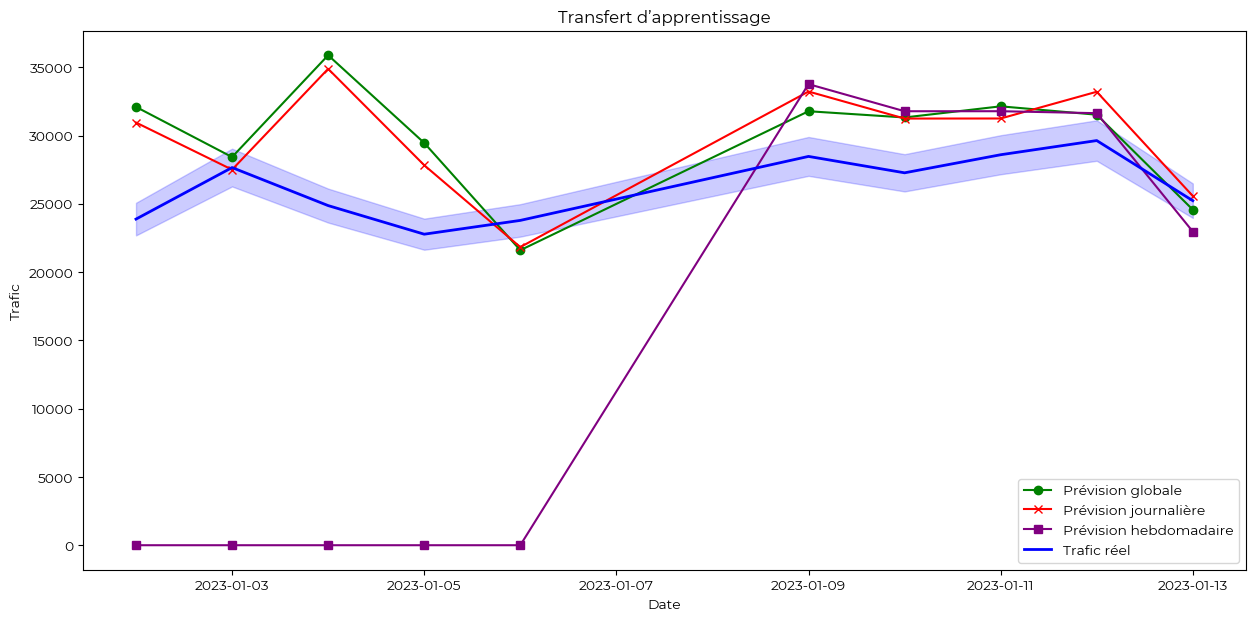

In [127]:
plot_test_results_from_df(data_test_forecast, 'Transfert d’apprentissage')

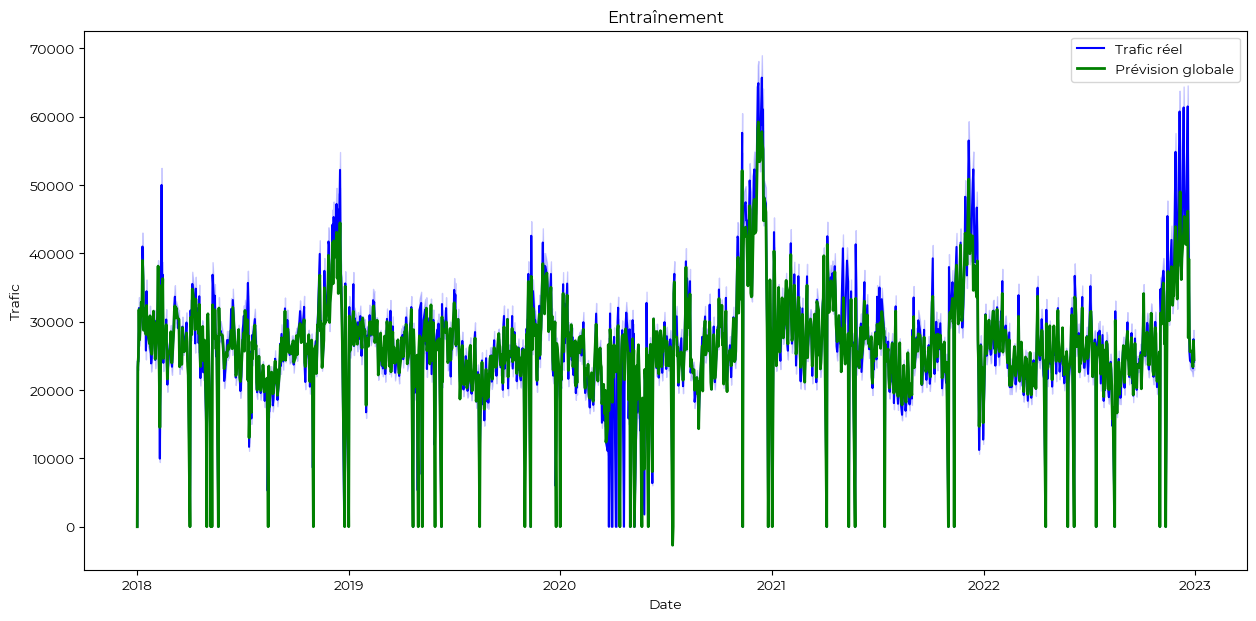

In [128]:
plot_train_results_from_df(data_train_forecast, 'Entraînement')

In [129]:
data_train_forecast['residuals'] = data_train_forecast['Trafic TG1'] - data_train_forecast['Prévision globale']

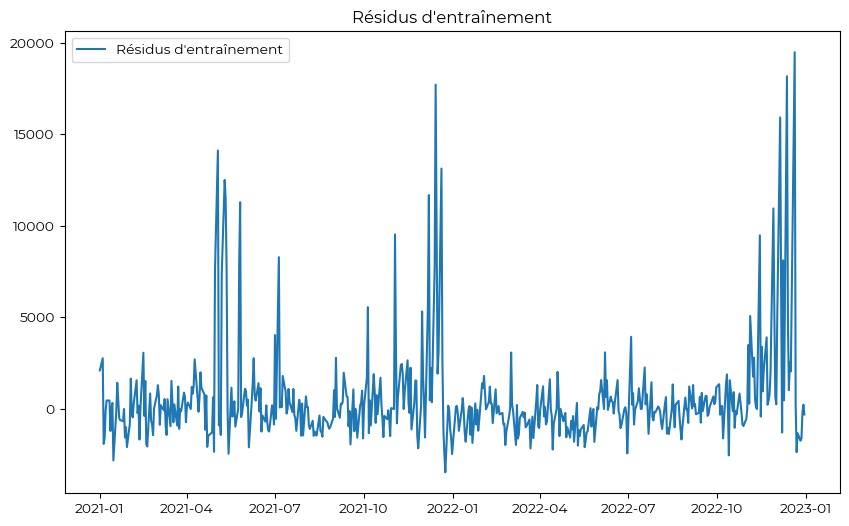

In [130]:
plt.figure(figsize=(10, 6))
plt.plot(data_train_forecast['2021-01-01':'2022-12-31'].index, data_train_forecast['2021-01-01':'2022-12-31']['residuals'], label="Résidus d'entraînement")
plt.title("Résidus d'entraînement")
plt.legend()
plt.show()

## Metrics

In [131]:
# Utilisation de la fonction:
forecast_columns = ['Prévision globale', 'Prévision journalière', 'Prévision hebdomadaire']
mapes = compute_mape_for_columns(data_test_forecast, 'Trafic TG1', forecast_columns)

for col, mape in mapes.items():
    print(f"MAPE {col} : {mape:.2f}%")

MAPE Prévision globale : 16.79%
MAPE Prévision journalière : 15.48%
MAPE Prévision hebdomadaire : 56.20%


In [132]:
# Utilisation de la fonction:
forecast_columns = ['Prévision globale']
mapes = compute_mape_for_columns(data_train_forecast, 'Trafic TG1', forecast_columns)

for col, mape in mapes.items():
    print(f"MAPE {col} : {mape:.2f}%")

MAPE Prévision globale : 7.74%
